In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [2]:
books_data_raw = pd.read_csv('data/Books_rating.csv')
books_data_raw

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,NaN,NaN,14/19,4.0,937612800,Difficult,"This is an extremely difficult book to digest,..."
2999996,B000NSLVCU,The Idea of History,NaN,A1SMUB9ASL5L9Y,jafrank,1/1,4.0,1331683200,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...
2999997,B000NSLVCU,The Idea of History,NaN,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",0/0,4.0,1180224000,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i..."
2999998,B000NSLVCU,The Idea of History,NaN,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",1/11,5.0,1163030400,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,..."


In [3]:
books_data = books_data_raw[['review/score', 'review/text']].copy()
books_data.rename(columns={'review/score': 'score', 'review/text': 'text'}, inplace=True)

In [4]:
# Remove rows with null values.
books_data = books_data.dropna()
len(books_data)

2999992

In [5]:
# TODO: use more 10000
books_data = books_data.head(50000)

<AxesSubplot: xlabel='score', ylabel='count'>

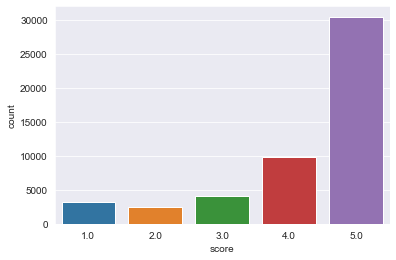

In [6]:
sns.countplot(x="score", data=books_data)

In [ ]:
X_raw = books_data.text
y_raw = books_data.score
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_raw)
X_tokenized = tokenizer.texts_to_sequences(X_raw)

In [21]:
X_padded = pad_sequences(X_tokenized, padding='post')

In [22]:
under_sampler = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = under_sampler.fit_resample(X_padded, y_raw)

<AxesSubplot: xlabel='score', ylabel='count'>

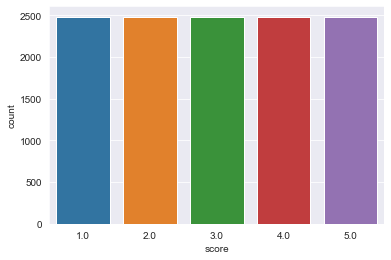

In [23]:
sns.countplot(x="score", data=pd.DataFrame(y_balanced))

In [24]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
vocab_size

105282

In [25]:
# One-hot encoding
y_one_hot = np_utils.to_categorical([int(score) - 1 for score in y_balanced])
y_one_hot[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_one_hot, test_size=0.20, random_state=42)

In [15]:
embeddings_dict = dict()
embeddings_file = open('data/glove.6B.300d.txt', encoding="utf8")
for line in embeddings_file:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = vector
embeddings_file.close()

In [16]:
embeddings_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding = embeddings_dict.get(word)
    if embedding is not None:
        embeddings_matrix[index] = embedding

In [27]:
model = Sequential()

embedding_layer = Embedding(
    vocab_size,
    300,
    weights=[embeddings_matrix],
    input_length=max([len(sent) for sent in X_balanced]),
    trainable=False
)
model.add(embedding_layer)

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5026, 300)         31584600  
                                                                 
 flatten_1 (Flatten)         (None, 1507800)           0         
                                                                 
 dense_3 (Dense)             (None, 32)                48249632  
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 79,835,453
Trainable params: 48,250,853
Non-trainable params: 31,584,600
_________________________________________________________________
None


In [28]:
BATCH_SIZE = 1024
EPOCHS = 10

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 158s 18s/step - loss: 1.6966 - accuracy: 0.2186 - val_loss: 1.6126 - val_accuracy: 0.2369
Epoch 2/10
8/8 [==============================] - 145s 18s/step - loss: 1.5016 - accuracy: 0.3413 - val_loss: 1.5738 - val_accuracy: 0.2912
Epoch 3/10
8/8 [==============================] - 116s 15s/step - loss: 1.3167 - accuracy: 0.5006 - val_loss: 1.5465 - val_accuracy: 0.3139
Epoch 4/10
8/8 [==============================] - 127s 17s/step - loss: 1.0679 - accuracy: 0.6567 - val_loss: 1.5669 - val_accuracy: 0.3189
Epoch 5/10
8/8 [==============================] - 119s 15s/step - loss: 0.8158 - accuracy: 0.7774 - val_loss: 1.5486 - val_accuracy: 0.3405
Epoch 6/10
8/8 [==============================] - 117s 14s/step - loss: 0.5984 - accuracy: 0.8628 - val_loss: 1.6013 - val_accuracy: 0.3426
Epoch 7/10
8/8 [==============================] - 112s 14s/step - loss: 0.4359 - accuracy: 0.9179 - val_loss: 1.6798 - val_accuracy: 0.3335
Epoch 8/10
8/8 [====

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [20]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

78/78 [==============================] - 1s 7ms/step - loss: 1.8507 - accuracy: 0.3219
Test Score: 1.8506834506988525
Test Accuracy: 0.3219316005706787
